In [1]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import scipy 
import numpy as np
import random as rd
import nltk
import pickle
import sklearn
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from datetime import datetime
from tqdm import tqdm

%matplotlib inline
nltk.download('stopwords')

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\igna-\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

# Parte 2

In [3]:
identity = pd.read_csv('train_identity.csv')
transaction = pd.read_csv('train_transaction.csv')

In [4]:
mergeado = identity.merge(transaction, left_on='TransactionID', right_on='TransactionID',
          how = 'right')
mergeado.drop(['TransactionID'], axis=1, inplace= True)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

 * Para separar el set de validacion considere que como tenemos un feature que involucra el tiempo, lo mejor es separar con el tiempo ordenado, quedandome con las ultimas transacciones.

Spliteo el 20% con el delta tiempo mayor

In [6]:
test_lenght = int(144233*0.2)
mergeado.sort_values(by = "TransactionDT")
train_lenght = (144233- test_lenght)
train = mergeado.iloc[0:train_lenght ,:]
test = mergeado.iloc[(144233- test_lenght):144233,:]

Encodeo el train set y el validation set

In [7]:
train['id_30'] = train['id_30'].astype(str).map(lambda x : 'Windows ' if x.find('Windows') != -1 else 
                                    'iOS' if x.find('iOS') != -1 else 
                                    'MacOs ' if x.find('MacOs') != -1 else
                                    'Desconocido' if x.find('nan') != -1 or x.find('Desconocido') != -1 else
                                    'Mac' if x.find('Mac') != -1 else
                                    'Linux' if x.find('Linux') != -1 else
                                    'Others'
                                   )

train['id_31'] = train['id_31'].astype(str).map(lambda x : 'Google' if x.find('chrome') != -1 or x.find('google') != -1 else 
                                    'Safari' if x.find('safari') != -1 else 
                                    'Internet Explorer' if x.find('ie') != -1 or x.find('edge') != -1 else
                                    'Firefox' if x.find('firefox') != -1 else
                                    'Opera' if x.find('opera') != -1 else
                                    'Samsung Browser' if x.find('samsung') != -1 or x.find('Samsung') != -1 else
                                    'Others'
                                   )

train.DeviceInfo = train.DeviceInfo.astype(str).map(lambda x : 'Windows' if x.find('Windows') != -1 else 
                                    'iOS' if x.find('iOS') != -1 else 
                                    'Mac ' if x.find('Android') != -1 else
                                    'rv' if x.find('rv') != -1 else
                                    'Mac' if x.find('Mac') != -1 else
                                    'SM' if x.find('SM') != -1 else
                                    'Others'
                                   )



X_cat = ['ProductCD','card4','id_34','id_15','id_23','id_30','id_31','DeviceType','DeviceInfo' ,'card6','P_emaildomain','R_emaildomain','M1','M2','M3','M4','M5','M6','M7','M8','M9']

cont_df = train.drop(X_cat,axis =1)
cont_df['id_12'] = cont_df['id_12'].replace('Found',1).replace('NotFound',0).astype(float)
cont_df['id_13'] = cont_df['id_13'].astype(float).fillna(cont_df['id_13'].mean()) 
cont_df['id_16'] = cont_df['id_16'].replace('Found',1).replace('NotFound',0).astype(float)
cont_df['id_27'] = cont_df['id_27'].replace('Found',1).replace('NotFound',0).astype(float)
cont_df['id_28'] = cont_df['id_28'].replace('Found',1).replace('New',0).astype(float)
cont_df['id_29'] = cont_df['id_29'].replace('Found',1).replace('NotFound',0).astype(float)
cont_df['id_13'] = cont_df['id_13'].astype(float).fillna(cont_df['id_13'].mean()) 
cont_df['id_33'] = cont_df['id_33'].astype(str).map(lambda x : 'nan' if x.find('nan') != -1 else
                                               int(x.split('x')[0])*int(x.split('x')[1])).astype(float)
media = cont_df['id_33'].mean()
cont_df['id_33'] = cont_df['id_33'] /media
cont_df['id_35'] = cont_df['id_35'].replace('T',1).replace('F',0).astype(float)
cont_df['id_36'] = cont_df['id_36'].replace('T',1).replace('F',0).astype(float)
cont_df['id_37'] = cont_df['id_37'].replace('T',1).replace('F',0).astype(float)
cont_df['id_38'] = cont_df['id_38'].replace('T',1).replace('F',0).astype(float)

cont_df.apply(lambda x: x.fillna(x.mean(),inplace = True)) 
cont_df.apply(lambda x: x.fillna(0,inplace = True)) 
cat_df = train[X_cat].fillna('Others')

In [8]:
encoders = []
for columna in X_cat:    
    ohe = OneHotEncoder(handle_unknown = 'ignore')  # drop='first'
    encoded_data = (ohe.fit_transform(cat_df[[columna]].astype(str)).todense().astype(int))
    encoders.append(ohe)
    encoded_data = pd.DataFrame(encoded_data, index = cont_df.index ).add_prefix(columna[0:8])
    cont_df = pd.concat([cont_df, encoded_data], axis=1)
train = cont_df

In [9]:
prom_features = []
for columna in train.drop(['isFraud'], axis=1).columns:
  prom_features.append(train[columna].mean())

In [10]:
with open('encod_parte2', 'wb') as file:
    pickle.dump(encoders, file)

In [11]:
test['id_30'] = test['id_30'].astype(str).map(lambda x : 'Windows ' if x.find('Windows') != -1 else 
                                    'iOS' if x.find('iOS') != -1 else 
                                    'MacOs ' if x.find('MacOs') != -1 else
                                    'Desconocido' if x.find('nan') != -1 or x.find('Desconocido') != -1 else
                                    'Mac' if x.find('Mac') != -1 else
                                    'Linux' if x.find('Linux') != -1 else
                                    'Others'
                                   )

test['id_31'] = test['id_31'].astype(str).map(lambda x : 'Google' if x.find('chrome') != -1 or x.find('google') != -1 else 
                                    'Safari' if x.find('safari') != -1 else 
                                    'Internet Explorer' if x.find('ie') != -1 or x.find('edge') != -1 else
                                    'Firefox' if x.find('firefox') != -1 else
                                    'Opera' if x.find('opera') != -1 else
                                    'Samsung Browser' if x.find('samsung') != -1 or x.find('Samsung') != -1 else
                                    'Others'
                                   )

test.DeviceInfo = test.DeviceInfo.astype(str).map(lambda x : 'Windows' if x.find('Windows') != -1 else 
                                    'iOS' if x.find('iOS') != -1 else 
                                    'Mac ' if x.find('Android') != -1 else
                                    'rv' if x.find('rv') != -1 else
                                    'Mac' if x.find('Mac') != -1 else
                                    'SM' if x.find('SM') != -1 else
                                    'Others'
                                   )



X_cat = ['ProductCD','card4','id_34','id_15','id_23','id_30','id_31','DeviceType','DeviceInfo' ,'card6','P_emaildomain','R_emaildomain','M1','M2','M3','M4','M5','M6','M7','M8','M9']

cont_df = test.drop(X_cat,axis =1)
cont_df['id_12'] = cont_df['id_12'].replace('Found',1).replace('NotFound',0).astype(float)
cont_df['id_13'] = cont_df['id_13'].astype(float).fillna(cont_df['id_13'].mean()) 
cont_df['id_16'] = cont_df['id_16'].replace('Found',1).replace('NotFound',0).astype(float)
cont_df['id_27'] = cont_df['id_27'].replace('Found',1).replace('NotFound',0).astype(float)
cont_df['id_28'] = cont_df['id_28'].replace('Found',1).replace('New',0).astype(float)
cont_df['id_29'] = cont_df['id_29'].replace('Found',1).replace('NotFound',0).astype(float)
cont_df['id_13'] = cont_df['id_13'].astype(float).fillna(cont_df['id_13'].mean()) 
cont_df['id_33'] = cont_df['id_33'].astype(str).map(lambda x : 'nan' if x.find('nan') != -1 else
                                               int(x.split('x')[0])*int(x.split('x')[1])).astype(float)
media = cont_df['id_33'].mean()
cont_df['id_33'] = cont_df['id_33'] /media
cont_df['id_35'] = cont_df['id_35'].replace('T',1).replace('F',0).astype(float)
cont_df['id_36'] = cont_df['id_36'].replace('T',1).replace('F',0).astype(float)
cont_df['id_37'] = cont_df['id_37'].replace('T',1).replace('F',0).astype(float)
cont_df['id_38'] = cont_df['id_38'].replace('T',1).replace('F',0).astype(float)

cont_df.apply(lambda x: x.fillna(x.mean(),inplace = True)) 
cont_df.apply(lambda x: x.fillna(0,inplace = True)) 
cat_df = test[X_cat].fillna('Others')

In [12]:
cont = 0 
for columna in X_cat:  
    encoded_data = (encoders[cont].transform(cat_df[[columna]].astype(str)).todense().astype(int))
    encoded_data = pd.DataFrame(encoded_data, index = cont_df.index ).add_prefix(columna[0:8])
    cont_df = pd.concat([cont_df, encoded_data], axis=1)
    cont += 1
test = cont_df

In [13]:
X_train = train.drop(['isFraud'], axis=1)
y_train = train.loc[:, 'isFraud']

In [14]:
X_test= test.drop(['isFraud'], axis=1)
y_test = test.loc[:, 'isFraud']

In [15]:
model = LogisticRegression(C=0.5, random_state = 1)

In [16]:
start_time = timer(None)
model.fit(X_train,y_train)
timer(start_time)


 Time taken: 0 hours 0 minutes and 13.33 seconds.


In [17]:
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    112635
           1       0.18      0.01      0.02      2752

    accuracy                           0.98    115387
   macro avg       0.58      0.50      0.50    115387
weighted avg       0.96      0.98      0.96    115387



In [18]:
roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

0.5886718371944342

In [19]:
# Create first pipeline for base without reducing features.
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

logistic = LogisticRegression()

# Create regularization penalty space
penalty = ['l2']

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

solver = ['newton-cg']

max_iter = uniform(loc = 0, scale=200)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty, max_iter = max_iter, solver = solver)


clf = RandomizedSearchCV(logistic ,param_distributions = hyperparameters , scoring = 'roc_auc',  cv = 3,n_iter = 4 , verbose=True, n_jobs=1, random_state = 1)

# Fit on data

best_clf = clf.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 22.4min finished


In [20]:
with open('model_backup', 'wb') as model_backup_file:
    pickle.dump(best_clf, model_backup_file)

In [21]:
roc_auc_score(y_test, best_clf.predict_proba(X_test)[:,1])

0.8266703095537394

Prueba competencia

In [41]:
import pickle
with open('model_backup', 'rb') as file:
    model=pickle.load(file)
file.close()

In [24]:
with open('encod_parte2', 'rb') as file:
    encoders=pickle.load(file)

In [25]:
#vacio ram
mergeado= None
train= None
cont_df= None
test= None
model = None
X_test= None
y_test= None
X_train= None
y_train= None 

In [33]:
identity = pd.read_csv('test_identity.csv')
transaction = pd.read_csv('test_transaction.csv')

In [34]:
mergeado = identity.merge(transaction, left_on='TransactionID', right_on='TransactionID',
          how = 'right')
mergeado.drop(['TransactionID'], axis=1, inplace= True)

In [35]:
identity = None
transaction =None

In [36]:
for c in mergeado.columns:
  if c[:2] == 'id':
    mergeado.rename(columns = {c:c.replace('-','_')},inplace= True)
mergeado

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
506687,-45.00,"266,704.00",nan,nan,-3.00,-10.00,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
506688,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
506689,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [37]:
mergeado['id_30'] = mergeado['id_30'].astype(str).map(lambda x : 'Windows ' if x.find('Windows') != -1 else 
                                    'iOS' if x.find('iOS') != -1 else 
                                    'MacOs ' if x.find('MacOs') != -1 else
                                    'Desconocido' if x.find('nan') != -1 or x.find('Desconocido') != -1 else
                                    'Mac' if x.find('Mac') != -1 else
                                    'Linux' if x.find('Linux') != -1 else
                                    'Others'
                                   )

mergeado.id_31 = mergeado['id_31'].astype(str).map(lambda x : 'Google' if x.find('chrome') != -1 or x.find('google') != -1 else 
                                    'Safari' if x.find('safari') != -1 else 
                                    'Internet Explorer' if x.find('ie') != -1 or x.find('edge') != -1 else
                                    'Firefox' if x.find('firefox') != -1 else
                                    'Opera' if x.find('opera') != -1 else
                                    'Samsung Browser' if x.find('samsung') != -1 or x.find('Samsung') != -1 else
                                    'Others'
                                   )

mergeado.DeviceInfo = mergeado['DeviceInfo'].astype(str).map(lambda x : 'Windows' if x.find('Windows') != -1 else 
                                    'iOS' if x.find('iOS') != -1 else 
                                    'Mac ' if x.find('Android') != -1 else
                                    'rv' if x.find('rv') != -1 else
                                    'Mac' if x.find('Mac') != -1 else
                                    'SM' if x.find('SM') != -1 else
                                    'Others'
                                   )



X_cat = ['ProductCD','card4','id_34','id_15','id_23','id_30','id_31','DeviceType','DeviceInfo' ,'card6','P_emaildomain','R_emaildomain','M1','M2','M3','M4','M5','M6','M7','M8','M9']

cont_df = mergeado.drop(X_cat,axis =1)
cont_df['id_12'] = cont_df['id_12'].replace('Found',1).replace('NotFound',0).astype(float)
cont_df['id_13'] = cont_df['id_13'].astype(float).fillna(cont_df['id_13'].mean()) 
cont_df['id_16'] = cont_df['id_16'].replace('Found',1).replace('NotFound',0).astype(float)
cont_df['id_27'] = cont_df['id_27'].replace('Found',1).replace('NotFound',0).astype(float)
cont_df['id_28'] = cont_df['id_28'].replace('Found',1).replace('New',0).astype(float)
cont_df['id_29'] = cont_df['id_29'].replace('Found',1).replace('NotFound',0).astype(float)
cont_df['id_13'] = cont_df['id_13'].astype(float).fillna(cont_df['id_13'].mean()) 
cont_df.id_33 = cont_df.id_33.astype(str).map(lambda x : 'nan' if x.find('nan') != -1 else
                                               int(x.split('x')[0])*int(x.split('x')[1])).astype(float)
media = cont_df.id_33.mean()
cont_df.id_33 = cont_df.id_33 /media
cont_df['id_35'] = cont_df['id_35'].replace('T',1).replace('F',0).astype(float)
cont_df['id_36'] = cont_df['id_36'].replace('T',1).replace('F',0).astype(float)
cont_df['id_37'] = cont_df['id_37'].replace('T',1).replace('F',0).astype(float)
cont_df['id_38'] = cont_df['id_38'].replace('T',1).replace('F',0).astype(float)

cont_df.apply(lambda x: x.fillna(x.mean(),inplace = True)) 
cont_df.apply(lambda x: x.fillna(0,inplace = True)) 
cat_df = mergeado[X_cat].fillna('Others')

In [38]:
cont = 0 
for columna in X_cat:  
    encoded_data = (encoders[cont].transform(cat_df[[columna]].astype(str)).todense().astype(int))
    encoded_data = pd.DataFrame(encoded_data, index = cont_df.index ).add_prefix(columna[0:5])
    cont_df = pd.concat([cont_df, encoded_data], axis=1)
    cont += 1
test = cont_df

In [39]:
sample = pd.read_csv('sample_submission.csv')

In [42]:
sample['isFraud'] = 1 - model.predict_proba(test)

In [43]:
sample.to_csv('submit.csv', index = False)

Resultado del submit a Kaggle


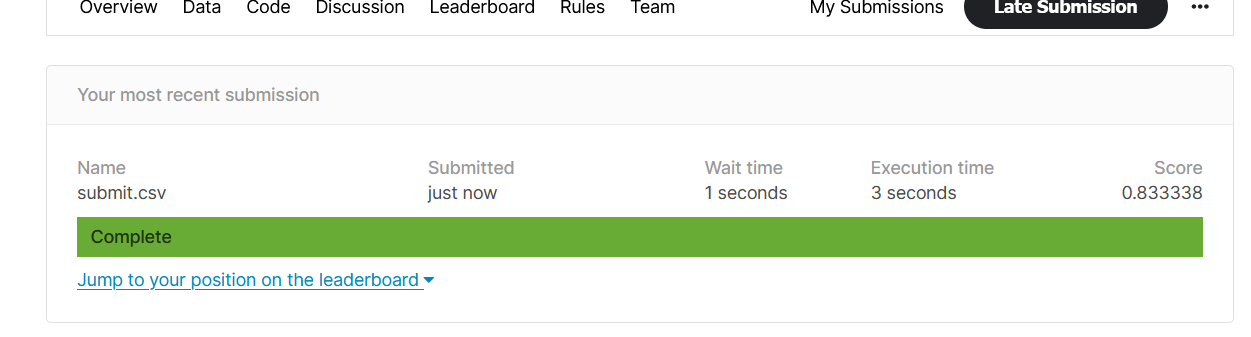

# Features mas importantes

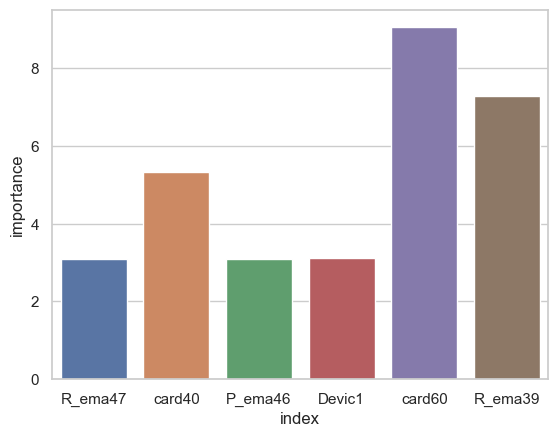

In [44]:
# get importance
importance = model.best_estimator_.coef_[0] / prom_features
# summarize feature importance
importance = np.asarray([abs(number) for number in importance])
ind = (np.argpartition(importance, -6)[-6:])
importance_top6 = importance[ind]
indices = test.columns[ind]
data = {'index': indices, 'importance': importance_top6}
df = pd.DataFrame(data)
# plot feature importance
sns.barplot(x="index", y="importance", data=df)
plt.show()